In [1]:
import json
import pandas as pd
from tqdm.notebook import tqdm
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from src.data_preprocessing.MemSum.utils import SentenceTokenizer
import nltk

nltk.download('rslp')

[nltk_data] Downloading package rslp to /home/TCU/erichm/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package rslp to /home/TCU/erichm/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [2]:
stok = nltk.data.load('tokenizers/punkt/portuguese.pickle')
stemmer = nltk.stem.RSLPStemmer() # RSLP Portuguese stemmer
# stemmer.stem("copiar") #copi
# stemmer.stem("paisagem") #pais
# stopwords = nltk.corpus.stopwords.words('portuguese')

additional_abbrevs = set(['art', 'arts', 'fl', 'fls', 'rel', 'Min', 'min', 'Rel', 'Vol', 'vol', 'ADV', 'adv', 'Adv', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x'])
stok._params.abbrev_types.update(additional_abbrevs)
print(stok._params.abbrev_types)

{'Rel', 'Vol', 'fl', 's.p', '9', 's.o.s', 'g', 'hui', 'cnt', 'p.j', '11s', 'inc', 'fbf', 'dr', 'op', 'a.p.s', 'sós', 'r', 'sr', 'adv', '8', 'bms', '1.6r', 'a.a', 'v.b', 'ix', 'cf', 'v', 'tel', 'q1', 'mrs', 'mr', 'qsp', 'g.r.e.s', 'fund', '14º', 'ii', 'mpb', 'ap', 'ADV', 'pen', 'zoe', '2', 'r.e.m', 'vi', 'p', 'j.b', 'fls', 'arts', 'uó', 'ltda', 'h', 'art', 'vs', 's', 'cip', 'vii', 'alt', 'j.c', 'ed', 't.j', 'vol', '3', 'rel', 'iii', '1', 'i', 'pág', '16o', 'Adv', '10', 'j.j', 'ipm', 'itr', 'a.s.s.j', 'jor', 'jr', 'av', '6', 'sra', 'nl', 'v.excia', 'prof', '5', 'iv', 'págs', 's.p.r', 'a.l.f', '1o', 'mens', 'fut', 'job', '7', 'viii', 'o.j', '13º', 'f.c', 'a.c', 'm.c.a', 's.a', 'x', 'min', '4', 'a.c.j', 'Min'}


In [3]:
# abbrev_candidates = set()
# abbrev_dict = {}
# for line_number, line in enumerate(train_corpus['text']):
#     for index, text in enumerate(line):
#         words = text.split(' ')
#         if len(words[-1]) < 5:
#             abbrev_candidates.add(words[-1])
#             # print(line_number, index)
#             # print(words[-2])
#             # print(line_number, index, words[-2], words[-1])
#             abbrev_dict.update({f'{line_number}-{index}': words[-1]})
# abbrev_candidates = set(abbrev_candidates)
# [print(f'{item}', end =' ') for item in sorted(list(abbrev_candidates))]
# print()

In [4]:
# abbrev_candidates
# train_corpus['text'][3][120:130]

In [5]:
train_corpus = [ json.loads(line) for line in open('rulingBR/train_v1.1.jsonl') ]
train_corpus[0].keys()
train_corpus = pd.DataFrame.from_dict(train_corpus)
train_corpus

,ementa,acordao,relatorio,voto
0,AGRAVO INTERNO EM RECURSO EXTRAORDINÁRIO. FUND...,"Vistos, relatados e discutidos estes autos, os...",O SENHOR MINISTRO ALEXANDRE DE MORAES (Relator...,O SENHOR MINISTRO ALEXANDRE DE MORAES (RELATOR...
1,DIREITO ADMINISTRATIVO. MILITAR. PROMOÇÃO. ATO...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...
2,HABEAS CORPUS. CONSTITUCIONAL. PENAL. TRÁFICO ...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...
3,RECLAMAÇÃO – PRETENDIDA SUBMISSÃO DO PROCESSO ...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...
4,Habeas corpus. Penal. Crime de estelionato pra...,"HC 110.845 Vistos, relatados e discutidos este...",O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Habe...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Conf...
...,...,...,...,...
6368,CONFLITO NEGATIVO DE ATRIBUIÇÕES - MINISTÉRIO ...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...
6369,DIREITO CONSTITUCIONAL E TRIBUTÁRIO. PIS. MEDI...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...
6370,EMBARGOS DE DECLARAÇÃO RECEBIDOS COMO AGRAVO R...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Na e...
6371,EMBARGOS DE DECLARAÇÃO NO AGRAVO DE INSTRUMENT...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Os embar...


In [6]:
val_corpus = [ json.loads(line) for line in open('rulingBR/val_v1.1.jsonl') ]
val_corpus[0].keys()
val_corpus = pd.DataFrame.from_dict(val_corpus)
val_corpus

,ementa,acordao,relatorio,voto
0,AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO CO...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,O SENHOR MINISTRO LUIZ FUX (RELATOR ): A prese...
1,RECURSO EXTRAORDINÁRIO – MATÉRIA FÁTICA E LEGA...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fev...,O SENHOR MINISTRO MARCO AURÉLIO (RELATOR) – Na...
2,DIREITO TRIBUTÁRIO. CONTRIBUIÇÃO SOCIAL. SALÁR...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...
3,DIREITO DO TRABALHO. RESPONSABILIDADE CIVIL. A...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...
4,AGRAVO REGIMENTAL EM RECURSO EXTRAORDINÁRIO. D...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO AYRES BRITTO (Relator) Trata...,O SENHOR MINISTRO AYRES BRITTO (Relator) Tenho...
...,...,...,...,...
2120,HABEAS CORPUS. PENAL. CRIME DE RACISMO. DESCLA...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...
2121,AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO CO...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....,A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....
2122,Terceiro agravo regimental no recurso extraord...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Luiz...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): O in...
2123,HABEAS CORPUS. PENAL. TRÁFICO INTERNACIONAL DE...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): 1....


In [7]:
test_corpus = [ json.loads(line) for line in open('rulingBR/test_v1.1.jsonl') ]
test_corpus[0].keys()
test_corpus = pd.DataFrame.from_dict(test_corpus)
test_corpus

,ementa,acordao,relatorio,voto
0,RECURSO EXTRAORDINÁRIO COM AGRAVO (LEI Nº 12.3...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...
1,AGRAVO REGIMENTAL NO AGRAVO DE INSTRUMENTO. TR...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): O presen...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Não assi...
2,DIREITO ADMINISTRATIVO. GRATIFICAÇÃO POR TEMPO...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...
3,DIREITO ADMINISTRATIVO. LEI Nº 11.064/2002. SE...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): A de...,A Senhora Ministra Rosa Weber (Relatora): Pree...
4,HABEAS CORPUS SUBSTITUTIVO DE AGRAVO REGIMENTA...,"Vistos, relatados e discutidos estes autos, ac...","O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como ...",O SENHOR MINISTRO MARCO AURÉLIO (RELATOR): PRI...
...,...,...,...,...
2120,EMBARGOS DE DECLARAÇÃO NO RECURSO EXTRAORDINÁR...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...
2121,PROCESSUAL PENAL. AGRAVO REGIMENTAL NO RECURSO...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...,O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...
2122,AGRAVO REGIMENTAL. HABEAS CORPUS. OFENSA AO PR...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): 1....
2123,DIREITO MATERIAL E PROCESSUAL DO TRABALHO. EXE...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...


In [8]:
%%time
train_corpus['input_completo'] = train_corpus['relatorio'] + ' ' + train_corpus['voto']
# train_corpus['text'] = [stok.tokenize(row.lower()) for row in tqdm(train_corpus['input_completo'])]
train_corpus['text_extractive'] = [stok.tokenize(row) for row in tqdm(train_corpus['input_completo'])]
train_corpus['text'] = [list(map(str.lower, row)) for row in tqdm(train_corpus['text_extractive'])]
# train_corpus['summary'] = [stok.tokenize(row.lower()) for row in tqdm(train_corpus['ementa'])]
train_corpus['summary_original'] = [stok.tokenize(row) for row in tqdm(train_corpus['ementa'])]
train_corpus['summary'] = [list(map(str.lower, row)) for row in tqdm(train_corpus['summary_original'])]
train_corpus.drop(columns=['summary_original'], inplace=True)
train_corpus

  0%|          | 0/6373 [00:00<?, ?it/s]

  0%|          | 0/6373 [00:00<?, ?it/s]

  0%|          | 0/6373 [00:00<?, ?it/s]

  0%|          | 0/6373 [00:00<?, ?it/s]

CPU times: user 15.1 s, sys: 133 ms, total: 15.2 s
Wall time: 15.2 s


,ementa,acordao,relatorio,voto,input_completo,text_extractive,text,summary
0,AGRAVO INTERNO EM RECURSO EXTRAORDINÁRIO. FUND...,"Vistos, relatados e discutidos estes autos, os...",O SENHOR MINISTRO ALEXANDRE DE MORAES (Relator...,O SENHOR MINISTRO ALEXANDRE DE MORAES (RELATOR...,O SENHOR MINISTRO ALEXANDRE DE MORAES (Relator...,[O SENHOR MINISTRO ALEXANDRE DE MORAES (Relato...,[o senhor ministro alexandre de moraes (relato...,"[agravo interno em recurso extraordinário., fu..."
1,DIREITO ADMINISTRATIVO. MILITAR. PROMOÇÃO. ATO...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[direito administrativo., militar., promoção.,..."
2,HABEAS CORPUS. CONSTITUCIONAL. PENAL. TRÁFICO ...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,[A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora):...,[a senhora ministra cármen lúcia - (relatora):...,"[habeas corpus., constitucional., penal., tráf..."
3,RECLAMAÇÃO – PRETENDIDA SUBMISSÃO DO PROCESSO ...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,[O SENHOR MINISTRO CELSO DE MELLO – (Relator):...,[o senhor ministro celso de mello – (relator):...,[reclamação – pretendida submissão do processo...
4,Habeas corpus. Penal. Crime de estelionato pra...,"HC 110.845 Vistos, relatados e discutidos este...",O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Habe...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Conf...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Habe...,[O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Hab...,[o senhor ministro dias toffoli (relator): hab...,"[habeas corpus., penal., crime de estelionato ..."
...,...,...,...,...,...,...,...,...
6368,CONFLITO NEGATIVO DE ATRIBUIÇÕES - MINISTÉRIO ...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,[O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATO...,[o senhor ministro ricardo lewandowski (relato...,[conflito negativo de atribuições - ministério...
6369,DIREITO CONSTITUCIONAL E TRIBUTÁRIO. PIS. MEDI...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[direito constitucional e tributário., pis., m..."
6370,EMBARGOS DE DECLARAÇÃO RECEBIDOS COMO AGRAVO R...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Na e...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,[embargos de declaração recebidos como agravo ...
6371,EMBARGOS DE DECLARAÇÃO NO AGRAVO DE INSTRUMENT...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Os embar...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,[O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-s...,[o senhor ministro luiz fux (relator): trata-s...,[embargos de declaração no agravo de instrumen...


In [9]:
%%time
val_corpus['input_completo'] = val_corpus['relatorio'] + ' ' + val_corpus['voto']
# val_corpus['text'] = [stok.tokenize(row.lower()) for row in tqdm(val_corpus['input_completo'])]
val_corpus['text_extractive'] = [stok.tokenize(row) for row in tqdm(val_corpus['input_completo'])]
val_corpus['text'] = [list(map(str.lower, row)) for row in tqdm(val_corpus['text_extractive'])]
# val_corpus['summary'] = [stok.tokenize(row.lower()) for row in tqdm(val_corpus['ementa'])]
val_corpus['summary_original'] = [stok.tokenize(row) for row in tqdm(val_corpus['ementa'])]
val_corpus['summary'] = [list(map(str.lower, row)) for row in tqdm(val_corpus['summary_original'])]
val_corpus.drop(columns=['summary_original'], inplace=True)
val_corpus

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

CPU times: user 5.07 s, sys: 29.3 ms, total: 5.1 s
Wall time: 5.09 s


,ementa,acordao,relatorio,voto,input_completo,text_extractive,text,summary
0,AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO CO...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,O SENHOR MINISTRO LUIZ FUX (RELATOR ): A prese...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,[O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-s...,[o senhor ministro luiz fux (relator): trata-s...,[agravo regimental no recurso extraordinário c...
1,RECURSO EXTRAORDINÁRIO – MATÉRIA FÁTICA E LEGA...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fev...,O SENHOR MINISTRO MARCO AURÉLIO (RELATOR) – Na...,O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fev...,[O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fe...,[o senhor ministro marco aurélio – em 24 de fe...,[recurso extraordinário – matéria fática e leg...
2,DIREITO TRIBUTÁRIO. CONTRIBUIÇÃO SOCIAL. SALÁR...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[direito tributário., contribuição social., sa..."
3,DIREITO DO TRABALHO. RESPONSABILIDADE CIVIL. A...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[direito do trabalho., responsabilidade civil...."
4,AGRAVO REGIMENTAL EM RECURSO EXTRAORDINÁRIO. D...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO AYRES BRITTO (Relator) Trata...,O SENHOR MINISTRO AYRES BRITTO (Relator) Tenho...,O SENHOR MINISTRO AYRES BRITTO (Relator) Trata...,[O SENHOR MINISTRO AYRES BRITTO (Relator) Trat...,[o senhor ministro ayres britto (relator) trat...,"[agravo regimental em recurso extraordinário.,..."
...,...,...,...,...,...,...,...,...
2120,HABEAS CORPUS. PENAL. CRIME DE RACISMO. DESCLA...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,[O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATO...,[o senhor ministro ricardo lewandowski (relato...,"[habeas corpus., penal., crime de racismo., de..."
2121,AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO CO...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....,A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....,A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....,[A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1...,[a senhora ministra cármen lúcia (relatora): 1...,[agravo regimental no recurso extraordinário c...
2122,Terceiro agravo regimental no recurso extraord...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Luiz...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): O in...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Luiz...,[O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Lui...,[o senhor ministro dias toffoli (relator): lui...,[terceiro agravo regimental no recurso extraor...
2123,HABEAS CORPUS. PENAL. TRÁFICO INTERNACIONAL DE...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): 1....,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,[O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): T...,[o senhor ministro teori zavascki (relator): t...,"[habeas corpus., penal., tráfico internacional..."


In [10]:
%%time
test_corpus['input_completo'] = test_corpus['relatorio'] + ' ' + test_corpus['voto']
# test_corpus['text'] = [stok.tokenize(row.lower()) for row in tqdm(test_corpus['input_completo'])]
test_corpus['text_extractive'] = [stok.tokenize(row) for row in tqdm(test_corpus['input_completo'])]
test_corpus['text'] = [list(map(str.lower, row)) for row in tqdm(test_corpus['text_extractive'])]
# test_corpus['summary'] = [stok.tokenize(row.lower()) for row in tqdm(test_corpus['ementa'])]
test_corpus['summary_original'] = [stok.tokenize(row) for row in tqdm(test_corpus['ementa'])]
test_corpus['summary'] = [list(map(str.lower, row)) for row in tqdm(test_corpus['summary_original'])]
test_corpus.drop(columns=['summary_original'], inplace=True)

test_corpus

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

CPU times: user 4.99 s, sys: 68.3 ms, total: 5.06 s
Wall time: 5.05 s


,ementa,acordao,relatorio,voto,input_completo,text_extractive,text,summary
0,RECURSO EXTRAORDINÁRIO COM AGRAVO (LEI Nº 12.3...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,[O SENHOR MINISTRO CELSO DE MELLO – (Relator):...,[o senhor ministro celso de mello – (relator):...,[recurso extraordinário com agravo (lei nº 12....
1,AGRAVO REGIMENTAL NO AGRAVO DE INSTRUMENTO. TR...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): O presen...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Não assi...,O SENHOR MINISTRO LUIZ FUX (RELATOR): O presen...,[O SENHOR MINISTRO LUIZ FUX (RELATOR): O prese...,[o senhor ministro luiz fux (relator): o prese...,"[agravo regimental no agravo de instrumento., ..."
2,DIREITO ADMINISTRATIVO. GRATIFICAÇÃO POR TEMPO...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[direito administrativo., gratificação por tem..."
3,DIREITO ADMINISTRATIVO. LEI Nº 11.064/2002. SE...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): A de...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): A de...,[A Senhora Ministra Rosa Weber (Relatora): A d...,[a senhora ministra rosa weber (relatora): a d...,"[direito administrativo., lei nº 11.064/2002.,..."
4,HABEAS CORPUS SUBSTITUTIVO DE AGRAVO REGIMENTA...,"Vistos, relatados e discutidos estes autos, ac...","O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como ...",O SENHOR MINISTRO MARCO AURÉLIO (RELATOR): PRI...,"O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como ...","[O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como...","[o senhor ministro marco aurélio – adoto, como...",[habeas corpus substitutivo de agravo regiment...
...,...,...,...,...,...,...,...,...
2120,EMBARGOS DE DECLARAÇÃO NO RECURSO EXTRAORDINÁR...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,[A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora):...,[a senhora ministra cármen lúcia - (relatora):...,[embargos de declaração no recurso extraordiná...
2121,PROCESSUAL PENAL. AGRAVO REGIMENTAL NO RECURSO...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...,O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...,O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...,[O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELAT...,[o senhor ministro luís roberto barroso (relat...,"[processual penal., agravo regimental no recur..."
2122,AGRAVO REGIMENTAL. HABEAS CORPUS. OFENSA AO PR...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): 1....,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,[O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): T...,[o senhor ministro teori zavascki (relator): t...,"[agravo regimental., habeas corpus., ofensa ao..."
2123,DIREITO MATERIAL E PROCESSUAL DO TRABALHO. EXE...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[direito material e processual do trabalho., e..."


In [11]:
train_corpus_final = train_corpus.drop(columns=['ementa', 'acordao', 'relatorio', 'voto'])
train_corpus_final

with open("data/custom_data/train_CUSTOM_raw.jsonl","w") as f:
    for _, row in train_corpus_final.iterrows():
        f.write(row.to_json() + "\n")

In [12]:
val_corpus_final = val_corpus.drop(columns=['ementa', 'acordao', 'relatorio', 'voto'])

with open("data/custom_data/val_CUSTOM_raw.jsonl","w") as f:
    for _, row in val_corpus_final.iterrows():
        f.write(row.to_json() + "\n")

In [13]:
test_corpus_final = test_corpus.drop(columns=['ementa', 'acordao', 'relatorio', 'voto'])

with open("data/custom_data/test_CUSTOM_raw.jsonl","w") as f:
    for _, row in test_corpus_final.iterrows():
        f.write(row.to_json() + "\n")

In [14]:
def preprocess(dataframe):
    from src.data_preprocessing.MemSum.utils import greedy_extract
    index, data = dataframe
    high_rouge_episodes = greedy_extract( data['text'], data['summary'], beamsearch_size = 3028 ) #max for training 3028 (was 3521)
    indices_list = []
    scores_list  = []

    for indices, score in high_rouge_episodes:
        indices_list.append( indices )
        scores_list.append(score)

    # data["indices"] = indices_list
    # data["score"] = score_list
    return indices_list, scores_list

In [15]:
%%time
with Pool(20) as p:
    indices_scores = list(tqdm(p.imap(preprocess, train_corpus_final.iterrows()), total=len(train_corpus_final)))
    
train_corpus_final['indices'] = [valores[0] for valores in indices_scores]
train_corpus_final['score'] = [valores[1] for valores in indices_scores]
train_corpus_final['text_extractive'] = ['\n'.join(np.asarray(text)[indices[np.argmax(score)]]) for text, indices, score in zip(train_corpus_final['text_extractive'], train_corpus_final['indices'], train_corpus_final['score'])]

  0%|          | 0/6373 [00:00<?, ?it/s]

CPU times: user 43.5 s, sys: 3.7 s, total: 47.2 s
Wall time: 7min 28s


In [16]:
%%time
with Pool(20) as p:
    indices_scores = list(tqdm(p.imap(preprocess, val_corpus_final.iterrows()), total=len(val_corpus_final)))
    
val_corpus_final['indices'] = [valores[0] for valores in indices_scores]
val_corpus_final['score'] = [valores[1] for valores in indices_scores]
val_corpus_final['text_extractive'] = ['\n'.join(np.asarray(text)[indices[np.argmax(score)]]) for text, indices, score in zip(val_corpus_final['text_extractive'], val_corpus_final['indices'], val_corpus_final['score'])]

  0%|          | 0/2125 [00:00<?, ?it/s]

CPU times: user 14.3 s, sys: 1.56 s, total: 15.9 s
Wall time: 3min 47s


In [17]:
%%time
with Pool(20) as p:
    indices_scores = list(tqdm(p.imap(preprocess, test_corpus_final.iterrows()), total=len(test_corpus_final)))
    
test_corpus_final['indices'] = [valores[0] for valores in indices_scores]
test_corpus_final['score'] = [valores[1] for valores in indices_scores]
test_corpus_final['text_extractive'] = ['\n'.join(np.asarray(text)[indices[np.argmax(score)]]) for text, indices, score in zip(test_corpus_final['text_extractive'], test_corpus_final['indices'], test_corpus_final['score'])]

  0%|          | 0/2125 [00:00<?, ?it/s]

CPU times: user 14.1 s, sys: 1.49 s, total: 15.6 s
Wall time: 2min 26s


In [18]:
train_corpus_final

,input_completo,text_extractive,text,summary,indices,score
0,O SENHOR MINISTRO ALEXANDRE DE MORAES (Relator...,A obrigação do recorrente em apresentar formal...,[o senhor ministro alexandre de moraes (relato...,"[agravo interno em recurso extraordinário., fu...","[[10, 9, 48, 14, 0, 24, 47, 35, 39, 26], [10, ...","[0.6984617639524853, 0.698097628059957, 0.6980..."
1,A Senhora Ministra Rosa Weber (Relatora): Cont...,A suposta ofensa aos postulados constitucionai...,[a senhora ministra rosa weber (relatora): con...,"[direito administrativo., militar., promoção.,...","[[71, 70, 80, 81, 38, 14, 67, 15, 52, 61], [71...","[0.8112948378196698, 0.8112948378196698, 0.810..."
2,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,4. Pelo que se tem na inicial da impetração no...,[a senhora ministra cármen lúcia - (relatora):...,"[habeas corpus., constitucional., penal., tráf...","[[72, 136, 79, 111, 113, 110, 21, 10, 116, 112...","[0.6820512820522819, 0.6812747926443469, 0.681..."
3,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,A pretendida desconstituição do ato de sanção ...,[o senhor ministro celso de mello – (relator):...,[reclamação – pretendida submissão do processo...,"[[73, 94, 64, 79, 83, 92, 60], [73, 94, 64, 79...","[0.3422126598715862, 0.34209649473646186, 0.34..."
4,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Habe...,"Ademais, não considero de reduzida expressivid...",[o senhor ministro dias toffoli (relator): hab...,"[habeas corpus., penal., crime de estelionato ...","[[31, 33, 32, 22, 21, 23, 27, 25], [31, 33, 32...","[0.7184576910166636, 0.7184576910166636, 0.718..."
...,...,...,...,...,...,...
6368,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,"Assim, seja em razão da pessoa, seja em razão ...",[o senhor ministro ricardo lewandowski (relato...,[conflito negativo de atribuições - ministério...,"[[25, 11, 10, 21, 14, 23, 20, 22, 34], [25, 11...","[0.8464691046668241, 0.8396633166222596, 0.838..."
6369,A Senhora Ministra Rosa Weber (Relatora): Cont...,As razões do agravo regimental não são aptas a...,[a senhora ministra rosa weber (relatora): con...,"[direito constitucional e tributário., pis., m...","[[60, 35, 31, 61, 10, 4, 47, 45, 6, 49], [60, ...","[0.5400183150193125, 0.5400183150193125, 0.540..."
6370,A Senhora Ministra Rosa Weber (Relatora): Cont...,"Ademais, esta Corte no julgamento do RE 795.46...",[a senhora ministra rosa weber (relatora): con...,[embargos de declaração recebidos como agravo ...,"[[123, 74, 134, 89, 88, 135, 125, 24, 117, 29,...","[0.7457575757585759, 0.7457287238319132, 0.744..."
6371,O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,"Nesse sentido, colaciono os seguintes julgados...",[o senhor ministro luiz fux (relator): trata-s...,[embargos de declaração no agravo de instrumen...,"[[19, 35, 11, 22, 9, 18, 5, 6, 1, 72, 2, 66, 7...","[0.790441266052021, 0.790441266052021, 0.79044..."


In [19]:
val_corpus_final

,input_completo,text_extractive,text,summary,indices,score
0,O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,"Súmulas 282 e 356 do STF, verbis: “É inadmissí...",[o senhor ministro luiz fux (relator): trata-s...,[agravo regimental no recurso extraordinário c...,"[[15, 51, 17, 16, 25, 29, 45, 31, 6, 52, 8, 2,...","[0.527942643056444, 0.5273105307167897, 0.5266..."
1,O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fev...,O prequestionamento não resulta da circunstânc...,[o senhor ministro marco aurélio – em 24 de fe...,[recurso extraordinário – matéria fática e leg...,"[[40, 41, 42, 19], [40, 41, 7, 42], [40, 41, 7...","[0.6160108548178429, 0.6128272367670748, 0.608..."
2,A Senhora Ministra Rosa Weber (Relatora): Cont...,"3. Embargos de declaração providos, com efeito...",[a senhora ministra rosa weber (relatora): con...,"[direito tributário., contribuição social., sa...","[[45, 27, 3, 32, 2, 46, 38, 21], [45, 27, 3, 3...","[0.4924552609099384, 0.48940822583544236, 0.48..."
3,A Senhora Ministra Rosa Weber (Relatora): Cont...,"Para divergir do Tribunal de origem, na hipóte...",[a senhora ministra rosa weber (relatora): con...,"[direito do trabalho., responsabilidade civil....","[[74, 2, 75, 15, 20, 68], [74, 2, 75, 15, 20, ...","[0.7828842532242712, 0.7828842532242712, 0.782..."
4,O SENHOR MINISTRO AYRES BRITTO (Relator) Trata...,(A/S) : FUNDAÇÃO GAÚCHA DO TRABALHO E AÇÃO SOC...,[o senhor ministro ayres britto (relator) trat...,"[agravo regimental em recurso extraordinário.,...","[[26, 0, 16, 1, 19, 8], [26, 0, 16, 1, 19, 13]]","[0.3385772913827273, 0.33822806764092445]"
...,...,...,...,...,...,...
2120,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,Em decisão paradigmática e que muito bem se co...,[o senhor ministro ricardo lewandowski (relato...,"[habeas corpus., penal., crime de racismo., de...","[[106, 26, 27, 184, 47, 135, 25], [106, 26, 27...","[0.5477221191516879, 0.5472222222232195, 0.546..."
2121,A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....,279 do Supremo Tribunal Federal: “Agravo regim...,[a senhora ministra cármen lúcia (relatora): 1...,[agravo regimental no recurso extraordinário c...,"[[12, 88, 69, 99, 21, 91, 93], [12, 88, 93, 69...","[0.6964164976345293, 0.6891566265070194, 0.680..."
2122,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Luiz...,"Agravo regimental provido.” Ressalte-se que, p...",[o senhor ministro dias toffoli (relator): lui...,[terceiro agravo regimental no recurso extraor...,"[[81, 42, 52, 82, 33, 74, 84, 76, 80, 77, 34],...","[0.6855748726464229, 0.6855748726464229, 0.685..."
2123,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,"Relativamente a fixação da pena-base, a postul...",[o senhor ministro teori zavascki (relator): t...,"[habeas corpus., penal., tráfico internacional...","[[20, 51, 69, 68, 73, 18, 19, 71, 50, 8, 6, 72...","[0.7046541705062875, 0.7046541705062875, 0.704..."


In [20]:
test_corpus_final

,input_completo,text_extractive,text,summary,indices,score
0,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,[o senhor ministro celso de mello – (relator):...,[recurso extraordinário com agravo (lei nº 12....,"[[0, 22, 5, 6], [0, 22, 5, 32], [0, 22, 31, 32...","[0.47178538390487845, 0.47178538390487845, 0.4..."
1,O SENHOR MINISTRO LUIZ FUX (RELATOR): O presen...,AI 789.678 AGR Considerando que a entrada em v...,[o senhor ministro luiz fux (relator): o prese...,"[agravo regimental no agravo de instrumento., ...","[[37, 119, 33, 36, 44, 31, 122, 34, 108, 32, 5...","[0.7357831562387008, 0.7357831562387008, 0.735..."
2,A Senhora Ministra Rosa Weber (Relatora): Cont...,A suposta ofensa aos postulados constitucionai...,[a senhora ministra rosa weber (relatora): con...,"[direito administrativo., gratificação por tem...","[[127, 126, 6, 40, 7, 101, 71, 25, 26, 104, 58...","[0.8278050778060824, 0.8278050778060824, 0.827..."
3,A Senhora Ministra Rosa Weber (Relatora): A de...,"Agravo interno conhecido e não provido, com ap...",[a senhora ministra rosa weber (relatora): a d...,"[direito administrativo., lei nº 11.064/2002.,...","[[41, 42, 31, 2, 24, 5, 4, 19, 22, 18, 32, 30]...","[0.7037186960286503, 0.7031266352705046]"
4,"O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como ...",A alteração do título prisional no curso do pr...,"[o senhor ministro marco aurélio – adoto, como...",[habeas corpus substitutivo de agravo regiment...,"[[43, 26, 5, 54, 55, 35, 24, 37, 13, 56, 9], [...","[0.3199408277955115, 0.3199408277955115, 0.319..."
...,...,...,...,...,...,...
2120,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,"4. Como assentado na decisão agravada, divergi...",[a senhora ministra cármen lúcia - (relatora):...,[embargos de declaração no recurso extraordiná...,"[[50, 51, 71, 85, 69, 56, 53, 24, 30, 22, 58, ...","[0.5027137042072651, 0.5027137042072651]"
2121,O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...,São apenas e unicamente 3 (três) fatos que o M...,[o senhor ministro luís roberto barroso (relat...,"[processual penal., agravo regimental no recur...","[[61, 78, 87, 52, 40, 42, 54, 53, 12, 51]]",[0.5960167005201251]
2122,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): 1....,[o senhor ministro teori zavascki (relator): t...,"[agravo regimental., habeas corpus., ofensa ao...","[[4, 23, 22, 33, 25, 21, 28, 11, 6], [4, 23, 2...","[0.7486306897212983, 0.7451921788857028]"
2123,A Senhora Ministra Rosa Weber (Relatora): Cont...,Possui repercussão geral a controvérsia acerca...,[a senhora ministra rosa weber (relatora): con...,"[direito material e processual do trabalho., e...","[[74, 60, 6, 75, 16, 1, 51, 32], [74, 60, 6, 7...","[0.6353211217269623, 0.6345031598773021, 0.632..."


In [21]:
with open("data/custom_data/train_CUSTOM_labelled.jsonl","w") as f:
    for _, row in train_corpus_final.iterrows():
        f.write(row.to_json() + "\n")

In [22]:
with open("data/custom_data/val_CUSTOM_labelled.jsonl","w") as f:
    for _, row in val_corpus_final.iterrows():
        f.write(row.to_json() + "\n")

In [23]:
with open("data/custom_data/test_CUSTOM_labelled.jsonl","w") as f:
    for _, row in test_corpus_final.iterrows():
        f.write(row.to_json() + "\n")

In [24]:
train_corpus['num_sentencas_texto'] = [len(row) for row in train_corpus['text']]
train_corpus['num_sentencas_resumo'] = [len(row) for row in train_corpus['summary']]

In [25]:
print('Entrada:')
print('Min:', np.min(train_corpus['num_sentencas_texto']), 
      'Mean:', round(np.mean(train_corpus['num_sentencas_texto']), 2), 
      'Max:', np.max(train_corpus['num_sentencas_texto']))
print('Percentil:', np.round(stats.percentileofscore(train_corpus['num_sentencas_texto'], 500), 2))
      
print('\nResumo:')
print('Min:', np.min(train_corpus['num_sentencas_resumo']), 
      'Mean:', round(np.mean(train_corpus['num_sentencas_resumo']), 2), 
      # 'Mean:', round(np.mean(train_corpus['num_sentencas_resumo']), 2), 
      'Max:', np.max(train_corpus['num_sentencas_resumo']))
print('Score:', np.round(stats.scoreatpercentile(train_corpus['num_sentencas_resumo'], 95), 2))
print('Percentil:', np.round(stats.percentileofscore(train_corpus['num_sentencas_resumo'], 30), 2))

Entrada:
Min: 10 Mean: 110.28 Max: 3028
Percentil: 98.57

Resumo:
Min: 1 Mean: 14.56 Max: 182
Score: 30.0
Percentil: 94.93


In [26]:
# print(train_corpus.iloc[0]['text'])
tamanho_sentencas = []
for index, sentencas in enumerate(train_corpus['text']):
    tamanho_sentencas_exemplo = []
    for sentenca in sentencas:
        tamanho_sentencas_exemplo.append(len(sentenca.split()))
        # print(sentenca.split())
        # print(tamanho_sentencas_exemplo)
        # break
    tamanho_sentencas.append(tamanho_sentencas_exemplo)
    # break
train_corpus['num_palavras_sentencas_texto'] = tamanho_sentencas
np.all(train_corpus['num_sentencas_texto'] == train_corpus['num_palavras_sentencas_texto'].apply(lambda tamanhos: len(tamanhos)))

True

In [27]:
num_sentencas_textos = [item for sublist in train_corpus['num_palavras_sentencas_texto'] for item in sublist]

In [28]:
print('Qtd Palavras das Sentencas:')
print('Min:', np.min(num_sentencas_textos), 
      'Mean:', round(np.mean(num_sentencas_textos), 2), 
      'Max:', np.max(num_sentencas_textos))
print('Percentil:', np.round(stats.percentileofscore(num_sentencas_textos, 100), 4))

Qtd Palavras das Sentencas:
Min: 1 Mean: 20.57 Max: 1752
Percentil: 98.9136


702788


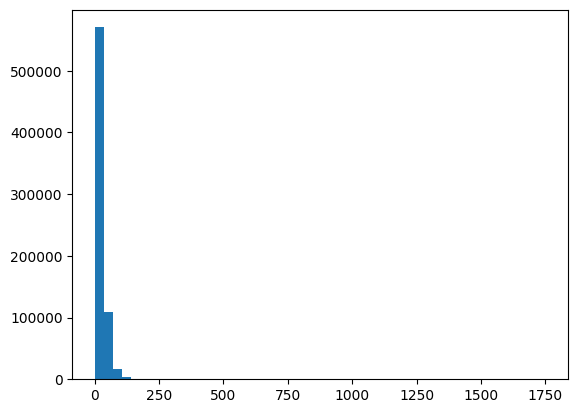

In [29]:
print(len(num_sentencas_textos))
n, bins, patches = plt.hist(num_sentencas_textos, 50, density=False)